# **Reinforcement Learning: Tarea 1, Estudio comparativo de algoritmos en un problema de k-armed bandit**

## **Autores:** Ana Gil Molina, José María García Ortiz y Levi Malest Villarreal

<br>

**Description:** En esta notebook realizaremos un experimento sobre el *problema del bandido de k brazos* con el que pretendemos comparar el desempeño de distintos algoritmos de la familia de mé todos de ascenso de gradiente (Softmax y gradiente de Preferencias), en base a estadísticos como el porcentaje de elecciones de brazo óptimas y el *regret* acumulado en función del tiempo.

Para poder interpretar los resultados, se incluyen unas gráficas con sus respectivos análisis y conclusiones al final de la sección **[2]** y **[3]**.

<br>

*This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.*

*For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html*



## **[1] - Preparación del entorno**


In [ ]:
#@title **Copiar el repositorio** ``JMGO-coding/k_brazos_GGM``.

!git clone https://github.com/JMGO-coding/k_brazos_GGM.git
!cd k_brazos_GGM/

Cloning into 'k_brazos_GGM'...
remote: Enumerating objects: 812, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 812 (delta 79), reused 16 (delta 16), pack-reused 671 (from 2)
Receiving objects: 100% (812/812), 29.79 MiB | 9.71 MiB/s, done.
Resolving deltas: 100% (410/410), done.


In [ ]:
#@title **Importamos todas las clases y funciones**

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/k_brazos_GGM')
sys.path.append('/content/k_brazos_GGM/src')

# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List

from algorithms import Algorithm, EpsilonGreedy, UCB2, Softmax, AdaptiveSoftmax, GradienteDePreferencias
from arms import ArmNormal, Bandit, ArmBinomial, ArmBernoulli
from plotting import plot_optimal_selections, plot_regret

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/k_brazos_GGM', '/content/k_brazos_GGM/src']


## **[2] - Experimento**

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado. Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan varios algoritmos y ee estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recompensas obtenidas en esas 500 veces.

In [ ]:
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):
    """
    Ejecuta experimentos comparativos entre diferentes algoritmos.

    :param bandit: Instancia de Bandit configurada para el experimento.
    :param algorithms: Lista de instancias de algoritmos a comparar.
    :param steps: Número de pasos de tiempo por ejecución.
    :param runs: Número de ejecuciones independientes.
    :return: Tuple de tres elementos: recompensas promedio, porcentaje de selecciones óptimas, y estadísticas de brazos.
    :rtype: Tuple of (np.ndarray, np.ndarray, list)
    """

    k = bandit.k
    optimal_arm = bandit.optimal_arm

    # Inicializar matrices para recompensas y selecciones óptimas
    rewards = np.zeros((len(algorithms), steps))
    optimal_selections = np.zeros((len(algorithms), steps))

    # Inicializar el regret global acumulado por cada algoritmo
    global_cumulative_regret_per_algo = np.zeros((len(algorithms),steps))

    for run in range(runs):
        # Crear una nueva instancia del bandit para cada ejecución
        current_bandit = Bandit(arms=bandit.arms)

        # Obtener la recompensa esperada óptima
        q_max = current_bandit.get_expected_value(current_bandit.optimal_arm)

        for algo in algorithms:
            algo.reset()

        # Inicializar recompensas acumuladas por algoritmo para esta ejecución
        total_rewards_per_algo = np.zeros(len(algorithms))  # Para análisis por rechazo

        # Inicializar recompensas acumuladas por algoritmo para esta ejecución
        # cumulative_rewards_per_algo = np.zeros(len(algorithms))

        num_choices_list = [[0 for _ in range(len(current_bandit.arms))] for _ in algorithms]   # para almacenar un conteo de las selecciones de cada brazo del bandido para cada algoritmo

        rewards_per_arm = np.zeros((len(algorithms), len(current_bandit.arms)))    # para almacenar las recompensas por cada brazo

        # Ejecutar cada algoritmo
        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm()
                reward = current_bandit.pull_arm(chosen_arm)
                algo.update(chosen_arm, reward)

                num_choices_list[idx][chosen_arm] += 1   # Actualizamos el conteo del brazo seleccionado en la estapa correspondiente del algoritmo ``algo``

                rewards[idx, step] += reward
                total_rewards_per_algo[idx] += reward

                rewards_per_arm[idx][chosen_arm] += reward

                global_cumulative_regret_per_algo[idx, step] = q_max*step - total_rewards_per_algo[idx]    # Actualziamos el regret acumulado en cada paso de decisión para cada algoritmo

                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

    # Promediar las recompensas y el regret sobre todas las ejecuciones
    rewards /= runs
    optimal_selections = (optimal_selections / runs) * 100
    cumulative_regret_per_algo = global_cumulative_regret_per_algo.copy()
    #proportional_cumulative_regret_per_algo = global_cumulative_regret_per_algo.copy()
    #proportional_cumulative_regret_per_algo /= runs
    rewards_per_arm /= runs

    return rewards, optimal_selections, num_choices_list, cumulative_regret_per_algo, rewards_per_arm

### **[2.1] - Ejecución del experimento con Distribución Normal**

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 6 algoritmos Softmax con 4 algoritmos de ascenso de gradiente.

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10        # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500    # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k))    # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar.
algorithms = [Softmax(k=k, tau = 0.1), Softmax(k=k, tau = 0.5), Softmax(k=k, tau = 1),
              AdaptiveSoftmax(k=k, tau_0 = 1, alpha=0.0000001), AdaptiveSoftmax(k=k, tau_0 = 1, alpha=0.000001), AdaptiveSoftmax(k=k, tau_0 = 1, alpha=0.00001),
              GradienteDePreferencias(k=k, alpha=0.5),
              GradienteDePreferencias(k=k, alpha=0.3), GradienteDePreferencias(k=k, alpha=0.1), GradienteDePreferencias(k=k, alpha=0.05)
             ]

# Extras
optimal_arms_list = [optimal_arm for _ in range(len(algorithms))]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, num_choices_list, proportional_cumulative_regret_per_algo, rewards_per_arm = run_experiment(bandit, algorithms, steps, runs)

# Estadísticas de cada brazo
arm_stats = [{arm: {"media": arm.mu, "std": arm.sigma} for arm in bandit.arms} for _ in range(len(algorithms))]

# Agregar la recompensa por brazo de cada algoritmo en el diccionario correspondiente
for algo_idx in range(len(algorithms)):  # Para cada algoritmo
    for arm_idx, arm in enumerate(bandit.arms):  # Para cada brazo del bandido
        arm_stats[algo_idx][arm]["reward"] = rewards_per_arm[algo_idx][arm_idx]  # Añadir el reward

Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


#### **Comparativa del porcentaje de elecciones de brazo óptimas**

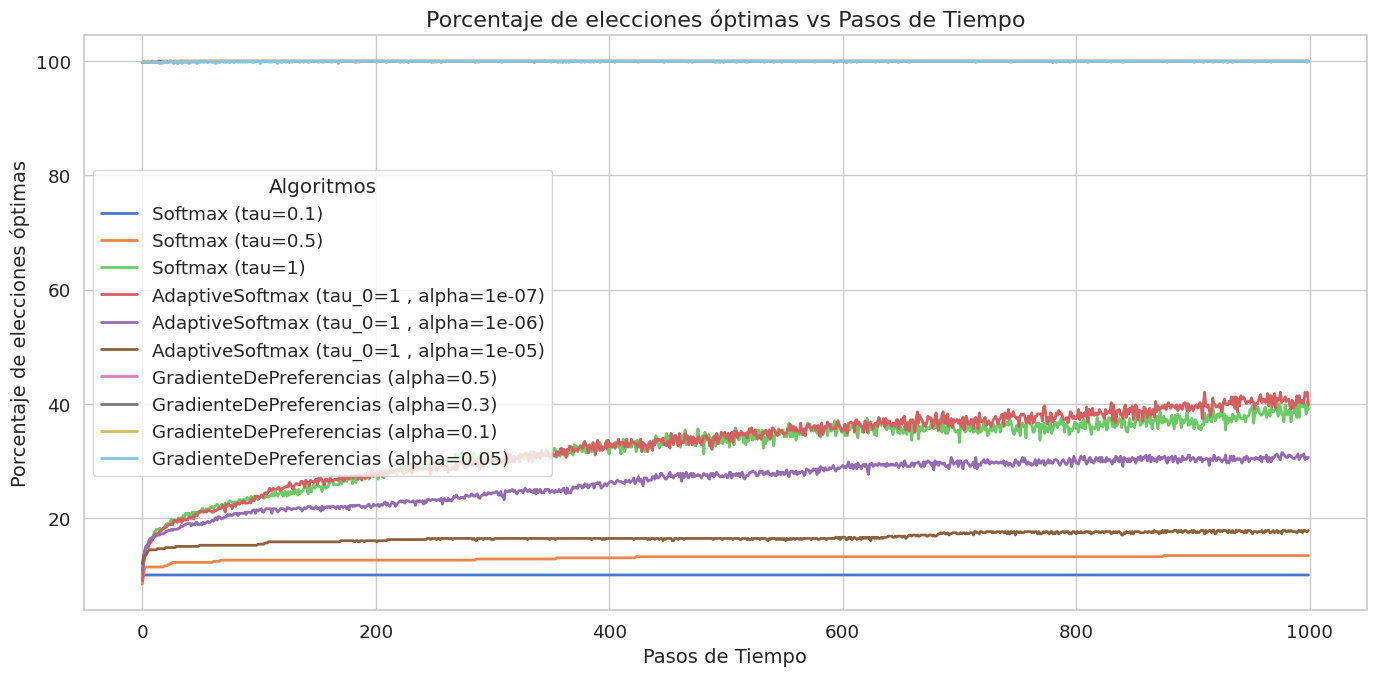

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Esta imagen muestra un gráfico de líneas titulado **"Porcentaje de elecciones óptimas vs Pasos de Tiempo"**, donde se analiza el desempeño de las diferentes estrategias de los algoritmos Softmax y $\varepsilon$-greedy consideradas en un entorno de multi-armed bandit. En este caso, en el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **porcentaje de elecciones óptimas** obtenido por cada algoritmo.

<br>

Resulta muy sorprendente de esta gráfica ver cómo todos los algoritmos de Gradiente de preferencias rozan el 100% de elecciones de brazo óptimo, mientras que los algoritmos Softmax tan solo llegan a 40% en el mejor de los casos.

<br>

Podemos intuir que esto se debe a la forma tan refinada de actualizar la política de decisinoes que poseen los algoritmos de gradiente de preferencias, que no solo actualizan la preferencia (o "probabilidad" de ser elegido) del brazo que se escoge en cada iteración, sino que además penaliza la preferencia de los brazos que no han sido escogidos. De esta forma, cuando el algoritmo detecte un brazo que ofrece muy buenas recompensas, con que lo demuestre en pocas elecciones será suficiente para que se *adhiera* a ese brazo por este sistema de *penalización de preferencias*.

<br>


Como mas elecciones de brazo óptimo no significa mejores recompensas a corto ni medio plazo necesariamente, no podemos sacar conclusiones sobre el desempeño de los algoritmos sin antes echar un vistazo al regret acumulado:



#### **Comparativa del regret acumulado**

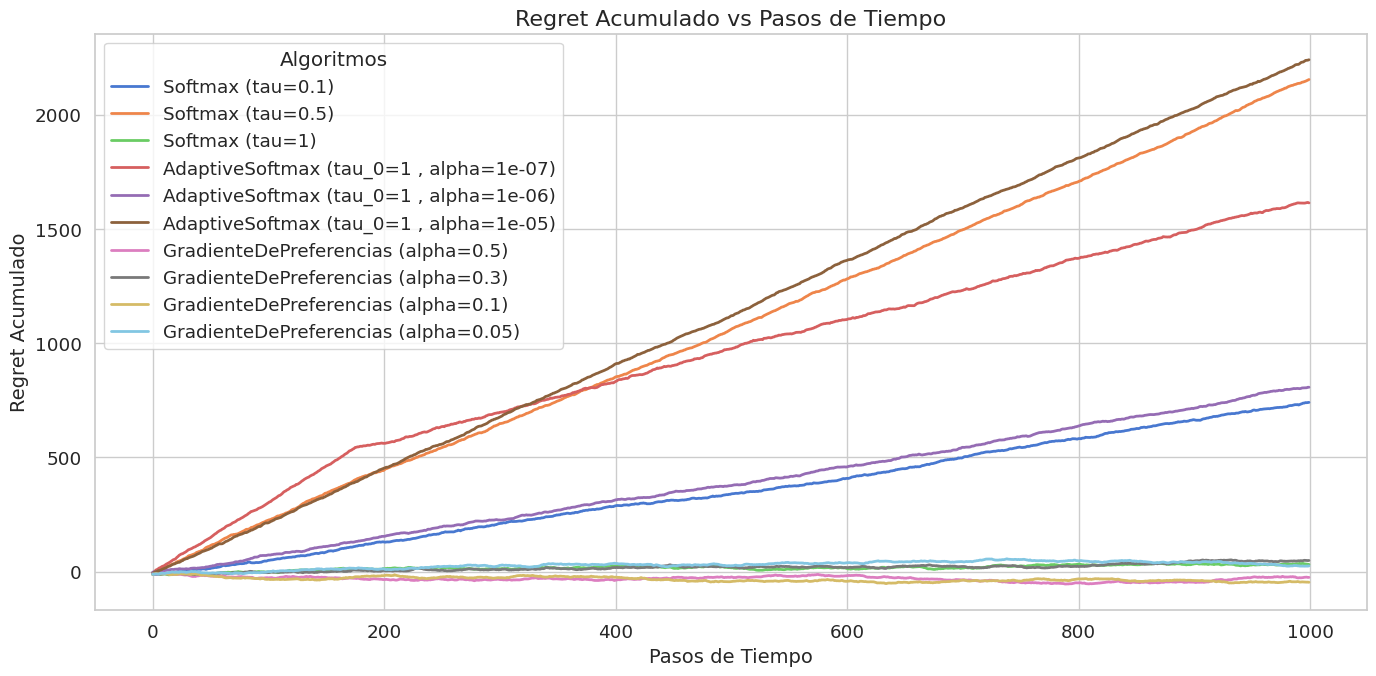

In [ ]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms)

Esta imagen muestra un gráfico de líneas titulado **"Regret acumulado vs Pasos de Tiempo"**, donde en el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **regret acumulado** obtenido por cada algoritmo **UCB2** y **$\varepsilon$-greedy** considerado.

<br>

como era de esperar según la gráfica de los porcentajes, el regret acumulado de los algoritmos de gradiente de preferencias es aproximadamente nulo en todos los casos. De hecho, con $\alpha = 0.1 , 0.5$ obtenemos un regret acumulado ligeramente negativo. Aunque esto es imposible teóricamente (tomando esperanzas en la fórmula del regret), en la práctica las variaciones muestrales de cada dstribución pueden hacer que incluso el propio brazo óptimo resulte mejor de lo esperado a corto o medio plazo.

<br>

Lo más destacable junto a lo anterior es que el algoritmo Softmax($\tau=1$) obtiene un regret acumulado casi nulo a pesar de que tan solo el 40% de sus elecciones de brazo son de brazo óptimo (en el paso 1000). Esto puede deberse a que el brazo óptimo esté retornando recompensas que en promedio (muestral) no difieran mucho de las de otros brazos sub-óptimos que son los que este algoritmo en concreto está priorizando.

Ahora pasamos a volver a mostrar el mismo gráfico, pero esta vez añadiendo la cota teórica para el regret, de forma que podamos comprobar si los regret acumulados obtenidos se mantienen por debajo de dicha cota.

Según Lai y Robbins, bajo ciertas condiciones se cumple:

$$ \liminf_{T\rightarrow \infty} \frac{\sum_{i:\mu_i < \mu^*}(\mu^* - \mu_i) E[n_i]}{ln(T)} \geq \sum_{i:\mu_i < \mu^*}\frac{\mu^* - \mu_i}{I(\mu_i, \mu^*)} = Cte $$

- El numerador es $L_T$: $q^* = \mu^*$, $q(a_i)=\mu_i$, $E[n_i] = E[N_T(a_i)]$
- Consecuencia: $L_T\geq Cte\cdot \ln(T)$
- Divergencia de Kullback-Leibler: $I(\mu_i, \mu^*) = \displaystyle \int_{-\infty}^{+\infty}\log\left(\frac{p_i(x)}{p^*(x)}\right)p_j(x)\,dx$
- Con distribución normal: $I(\mu_i, \mu^*) = \frac{(\mu_i - \mu^*)^2}{2\sigma^2}$

In [ ]:
def I_normal(mu_i, mu_star, sigma_2):
    """Divergencia KL entre dos normales con la misma varianza."""
    return (mu_i - mu_star)**2 / (2 * sigma_2)

mus = [bandit.get_expected_value(num_arm) for num_arm in range(len(bandit.arms))]    # Medias de los brazos
mu_star = max(mus)   # Media del brazo óptimo
sigma_2 = 1          # Varianza de los brazos (igual para todos)

# Calcular la constante
cte = sum((mu_star - mu) / I_normal(mu, mu_star, sigma_2) for mu in mus if mu < mu_star)

# Cota teórica
theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])

<ipython-input-7-e8a6397acd45>:13: RuntimeWarning: divide by zero encountered in log
  theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])


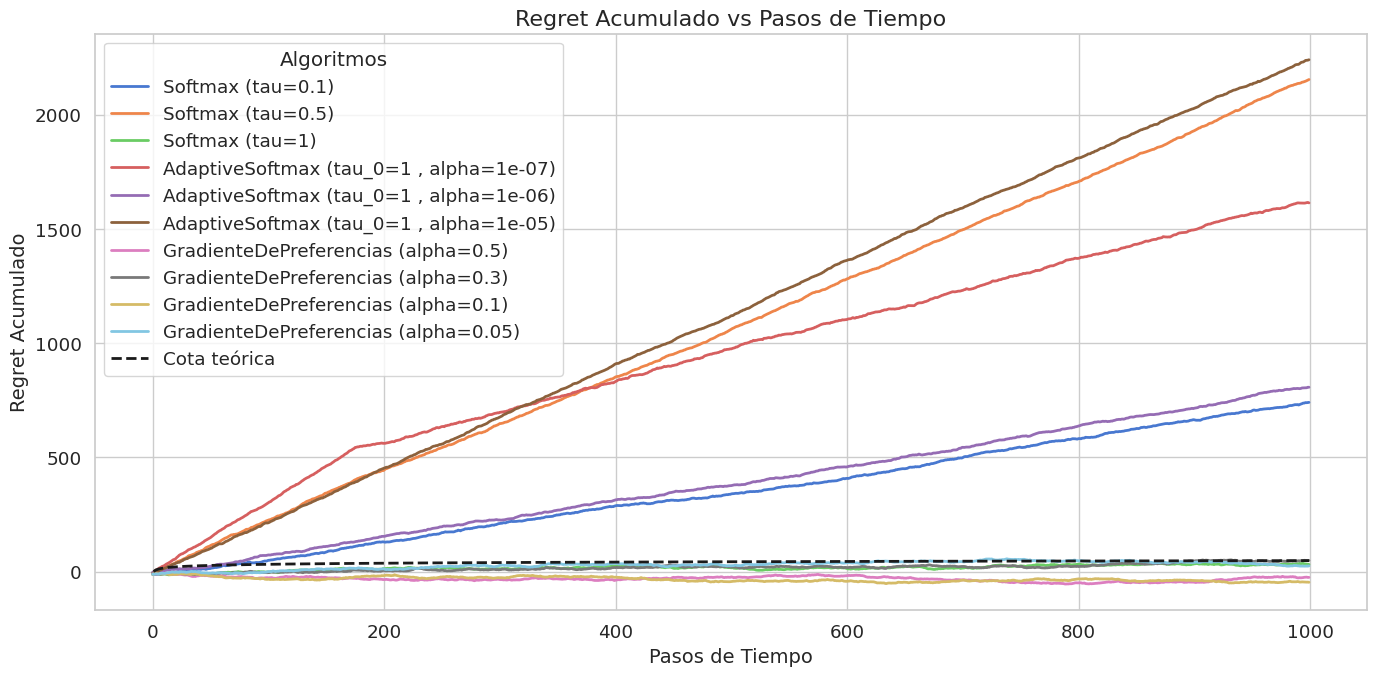

In [ ]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms, theoretical_bound = theoretical_bound)

Efectivamente, el regret acumulado se mantiene muy por debajo de la cota teórica con todos los algoritmos considerados, mostrando el buen desempeño en general de los algoritmos estudiados.

### **[2.2] - Ejecución del experimento con Distribución Bernoulli**

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución Bernoulli. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan de nuevo los mismos algoritmos.

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10        # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500    # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBernoulli.generate_arms(k))    # Generar un bandido con k brazos de distribución Bernoulli
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar.
algorithms = [Softmax(k=k, tau = 0.1), Softmax(k=k, tau = 0.5), Softmax(k=k, tau = 1),
              AdaptiveSoftmax(k=k, tau_0 = 1, alpha=0.0000001), AdaptiveSoftmax(k=k, tau_0 = 1, alpha=0.000001), AdaptiveSoftmax(k=k, tau_0 = 1, alpha=0.00001),
              GradienteDePreferencias(k=k, alpha=0.5),
              GradienteDePreferencias(k=k, alpha=0.3), GradienteDePreferencias(k=k, alpha=0.1), GradienteDePreferencias(k=k, alpha=0.05)
             ]

# Extras
optimal_arms_list = [optimal_arm for _ in range(len(algorithms))]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, num_choices_list, proportional_cumulative_regret_per_algo, rewards_per_arm = run_experiment(bandit, algorithms, steps, runs)

# Estadísticas de cada brazo
arm_stats = [{arm: {"media": arm.mu} for arm in bandit.arms} for _ in range(len(algorithms))]

# Agregar la recompensa por brazo de cada algoritmo en el diccionario correspondiente
for algo_idx in range(len(algorithms)):  # Para cada algoritmo
    for arm_idx, arm in enumerate(bandit.arms):  # Para cada brazo del bandido
        arm_stats[algo_idx][arm]["reward"] = rewards_per_arm[algo_idx][arm_idx]  # Añadir el reward

Bandit with 10 arms: ArmBernoulli(p=0.3745401188473625), ArmBernoulli(p=0.9507143064099162), ArmBernoulli(p=0.7319939418114051), ArmBernoulli(p=0.5986584841970366), ArmBernoulli(p=0.15601864044243652), ArmBernoulli(p=0.15599452033620265), ArmBernoulli(p=0.05808361216819946), ArmBernoulli(p=0.8661761457749352), ArmBernoulli(p=0.6011150117432088), ArmBernoulli(p=0.7080725777960455)
Optimal arm: 2 with expected reward=0.9507143064099162


#### **Comparativa del porcentaje de elecciones de brazo óptimas**

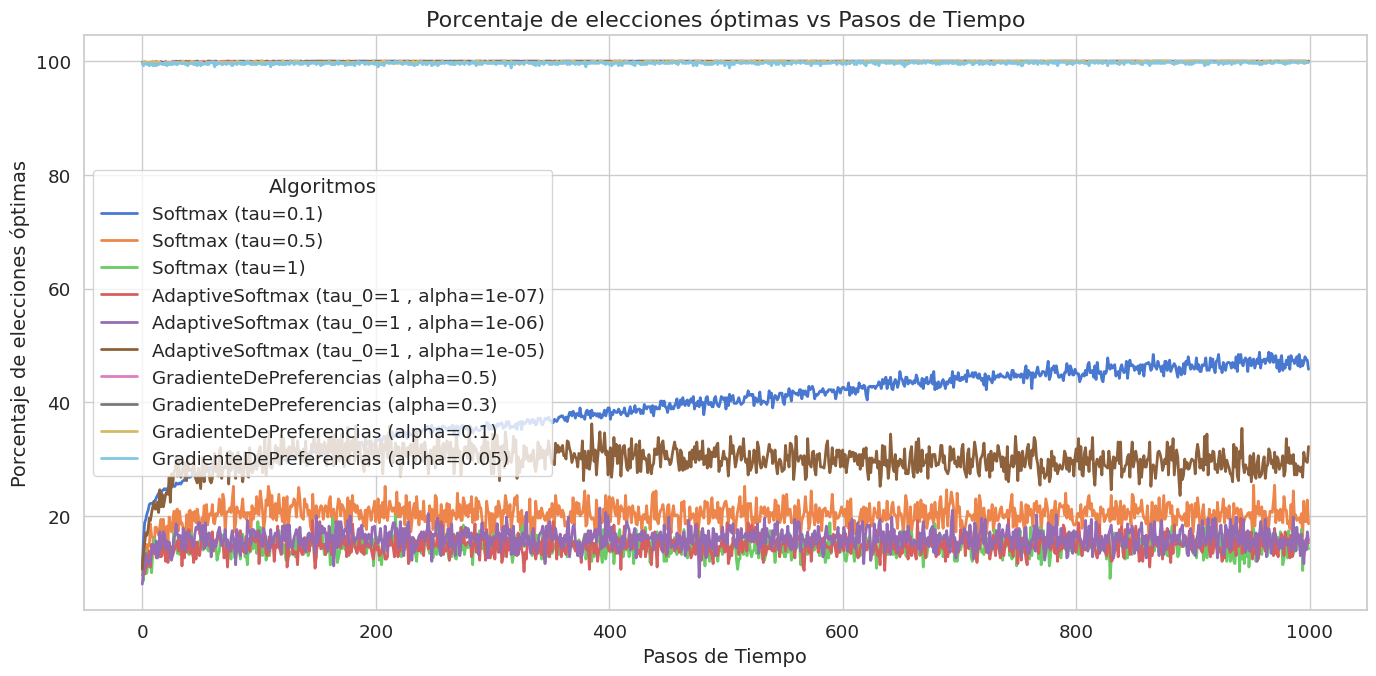

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

De nuevo, todas las técnicas de gradiente de preferencias obtienen casi un 100% de elecciones de brazo óptimo, pero esta vez Softmax($\tau = 0.1$) consigue llegar al 50% en el paso 1000. El resto de técnicas Softmax tnato estándar como adaptativo quedan por debajo del 30% en el paso 1000.

#### **Comparativa del regret acumulado**

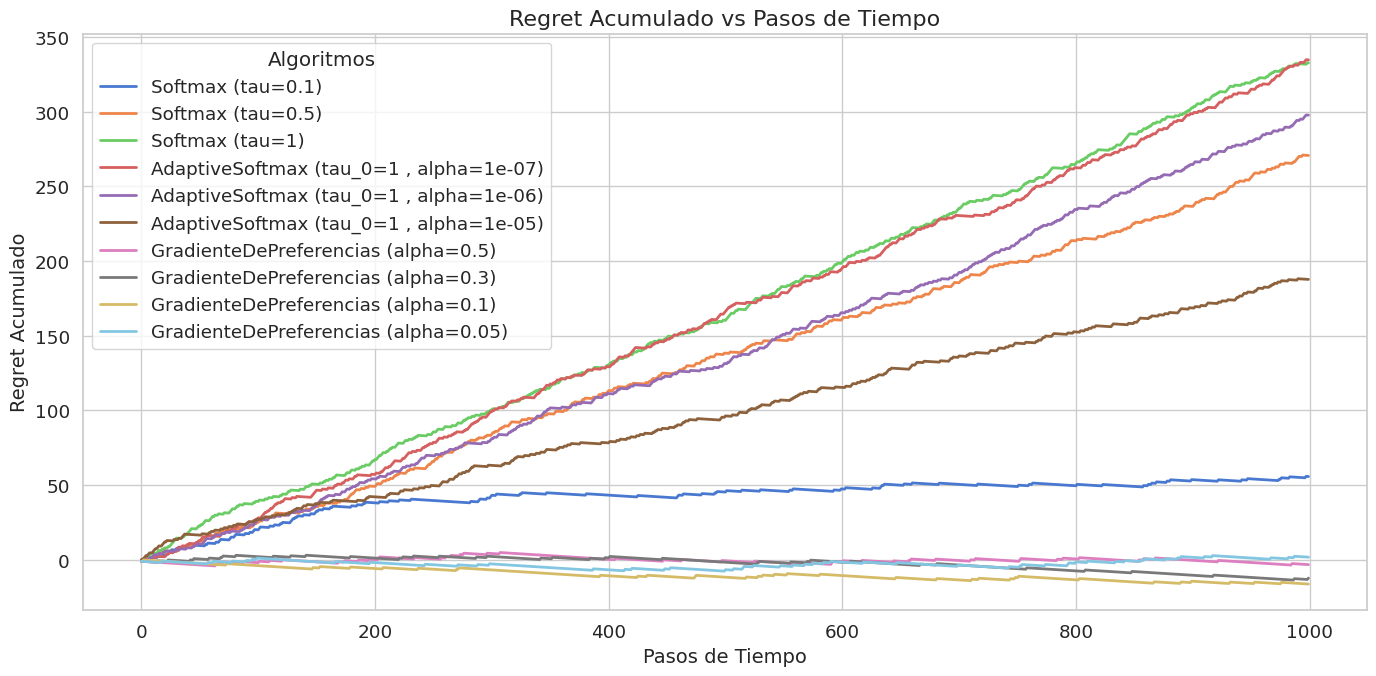

In [ ]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms)

Como ocurría con el bandido de brazos normales, los mejores algoritmos en cuanto al desempeño en la práctica han sido los de gradiente de preferencias, alcanzando regrets acumulados incluso más bajos que con brazos normales (véase $\alpha = 0.1, 0.3$). También Ofrece un buen rendimiento el Softmax($\tau = 0.1$). Estos algoritmos son los únicos que consiguen "estabilizar" su regret acumulado conforme aumentan los pasos de tiempo. Los demas crecen de forma lineal.

Ahora pasamos a volver a mostrar el mismo gráfico, pero esta vez añadiendo la cota teórica para el regret, de forma que podamos comprobar si los regret acumulados obtenidos se mantienen por debajo de dicha cota.

Según Lai y Robbins, bajo ciertas condiciones se cumple:

$$ \liminf_{T\rightarrow \infty} \frac{\sum_{i:\mu_i < \mu^*}(\mu^* - \mu_i) E[n_i]}{ln(T)} \geq \sum_{i:\mu_i < \mu^*}\frac{\mu^* - \mu_i}{I(\mu_i, \mu^*)} = Cte $$

- El numerador es $L_T$: $q^* = \mu^*$, $q(a_i)=\mu_i$, $E[n_i] = E[N_T(a_i)]$
- Consecuencia: $L_T\geq Cte\cdot \ln(T)$
- Divergencia de Kullback-Leibler: $I(\mu_i, \mu^*) = \displaystyle \int_{-\infty}^{+\infty}\log\left(\frac{p_i(x)}{p^*(x)}\right)p_j(x)\,dx$
- Con distribución normal: $I(\mu_i, \mu^*) = \mu_i \ln \left( \frac{\mu_i}{\mu^*} \right) + (1 - \mu_i) \ln \left( \frac{1 - \mu_i}{1 - \mu^*} \right)$

In [ ]:
def I_bernoulli(mu_i, mu_star):
    """Divergencia KL entre dos Bernoulli."""
    return mu_i * np.log(mu_i / mu_star) + (1 - mu_i) * np.log((1 - mu_i) / (1 - mu_star))

mus = [bandit.get_expected_value(num_arm) for num_arm in range(len(bandit.arms))]    # Medias de los brazos
mu_star = max(mus)   # Media del brazo óptimo

# Calcular la constante
cte = sum((mu_star - mu) / I_bernoulli(mu, mu_star) for mu in mus if mu < mu_star)

# Cota teórica
theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])

<ipython-input-12-14c133996bdd>:12: RuntimeWarning: divide by zero encountered in log
  theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])


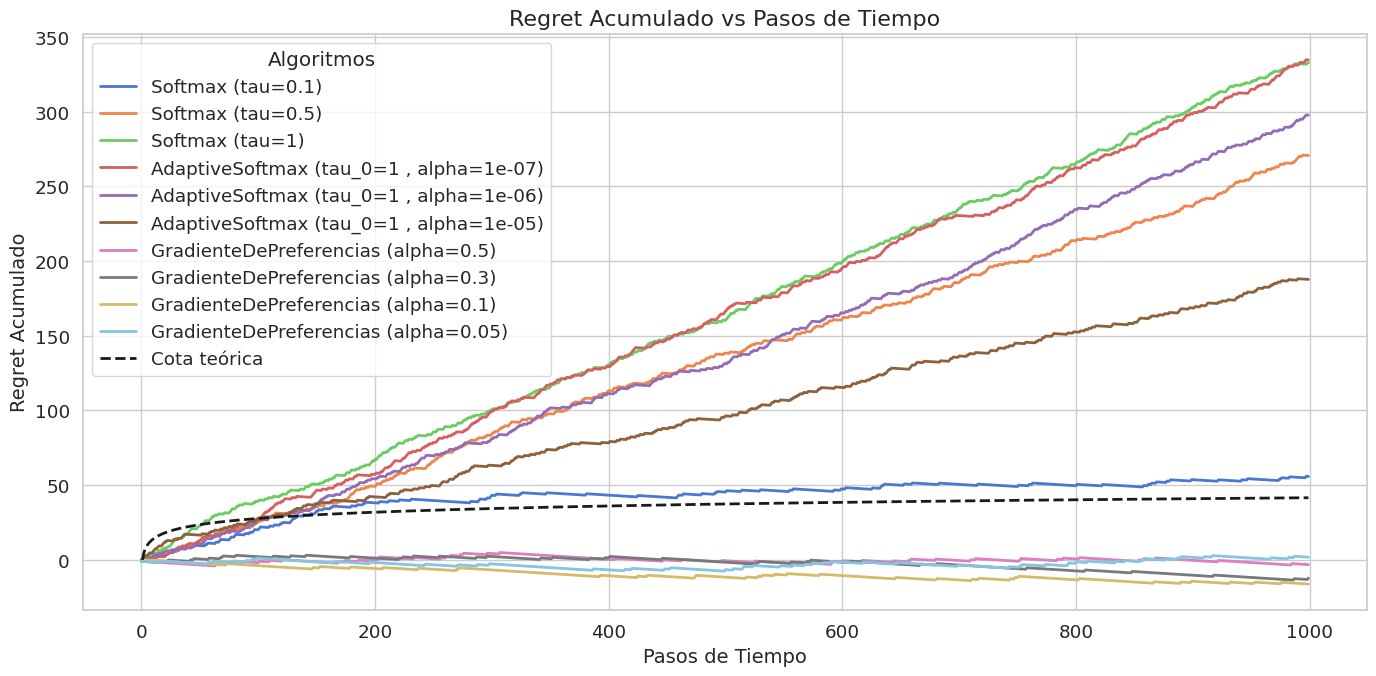

In [ ]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms, theoretical_bound = theoretical_bound)

El regret acumulado se mantiene muy por debajo de la cota teórica con los algoritmos de GradienteDePreferencias, mostrando el buen desempeño de dichos algoritmos frente al resto.

### **[2.3] - Ejecución del experimento con Distribución Binomial**

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución Binomial.

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10        # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500    # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBinomial.generate_arms(k))    # Generar un bandido con k brazos de distribución Binomial
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar.
algorithms = [Softmax(k=k, tau = 0.1), Softmax(k=k, tau = 0.5), Softmax(k=k, tau = 1),
              AdaptiveSoftmax(k=k, tau_0 = 1, alpha=0.0000001), AdaptiveSoftmax(k=k, tau_0 = 1, alpha=0.000001), AdaptiveSoftmax(k=k, tau_0 = 1, alpha=0.00001),
              GradienteDePreferencias(k=k, alpha=0.5),
              GradienteDePreferencias(k=k, alpha=0.3), GradienteDePreferencias(k=k, alpha=0.1), GradienteDePreferencias(k=k, alpha=0.05)
             ]

# Extras
optimal_arms_list = [optimal_arm for _ in range(len(algorithms))]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, num_choices_list, proportional_cumulative_regret_per_algo, rewards_per_arm = run_experiment(bandit, algorithms, steps, runs)

# Estadísticas de cada brazo
arm_stats = [{arm: {"media": arm.mu} for arm in bandit.arms} for _ in range(len(algorithms))]

# Agregar la recompensa por brazo de cada algoritmo en el diccionario correspondiente
for algo_idx in range(len(algorithms)):  # Para cada algoritmo
    for arm_idx, arm in enumerate(bandit.arms):  # Para cada brazo del bandido
        arm_stats[algo_idx][arm]["reward"] = rewards_per_arm[algo_idx][arm_idx]  # Añadir el reward

Bandit with 10 arms: ArmBinomial(n=20, p=0.21233911067827616), ArmBinomial(n=2, p=0.8661761457749352), ArmBinomial(n=9, p=0.9507143064099162), ArmBinomial(n=8, p=0.5247564316322378), ArmBinomial(n=5, p=0.18340450985343382), ArmBinomial(n=15, p=0.7080725777960455), ArmBinomial(n=1, p=0.9699098521619943), ArmBinomial(n=11, p=0.2912291401980419), ArmBinomial(n=18, p=0.5986584841970366), ArmBinomial(n=4, p=0.15599452033620265)
Optimal arm: 9 with expected reward=10.775852715546659


#### **Comparativa del porcentaje de elecciones de brazo óptimas**

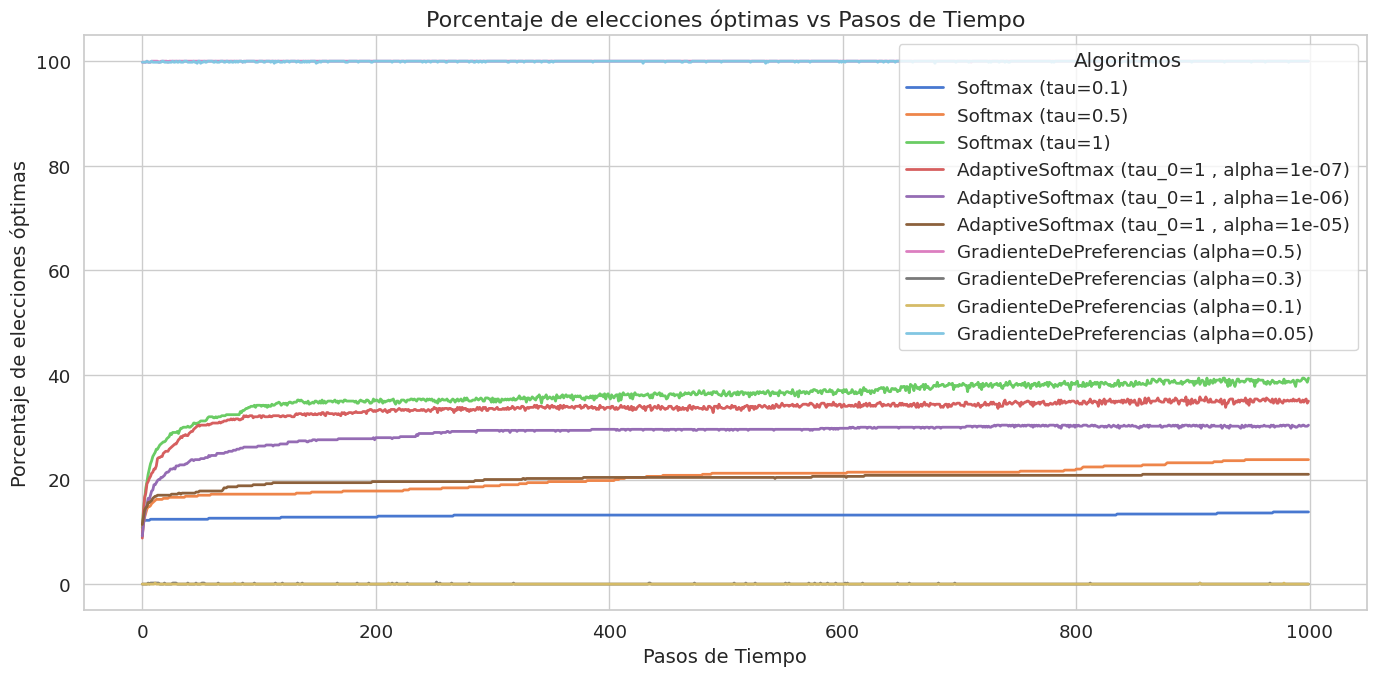

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

Algunos algoritmos de gradiente de preferencias se acercan al 100% de elecciones de brazo optimo y otros se quedan alrededor del 0%. A priori no sabemos cómo van a diferir los rendimientos de estos dos grupos de algoritmos, pero lo que si tenemos por seguro es que los métodos de Softmax siguen en la misma línea en lo que a esta métrica se refiere.

#### **Comparativa del regret acumulado**

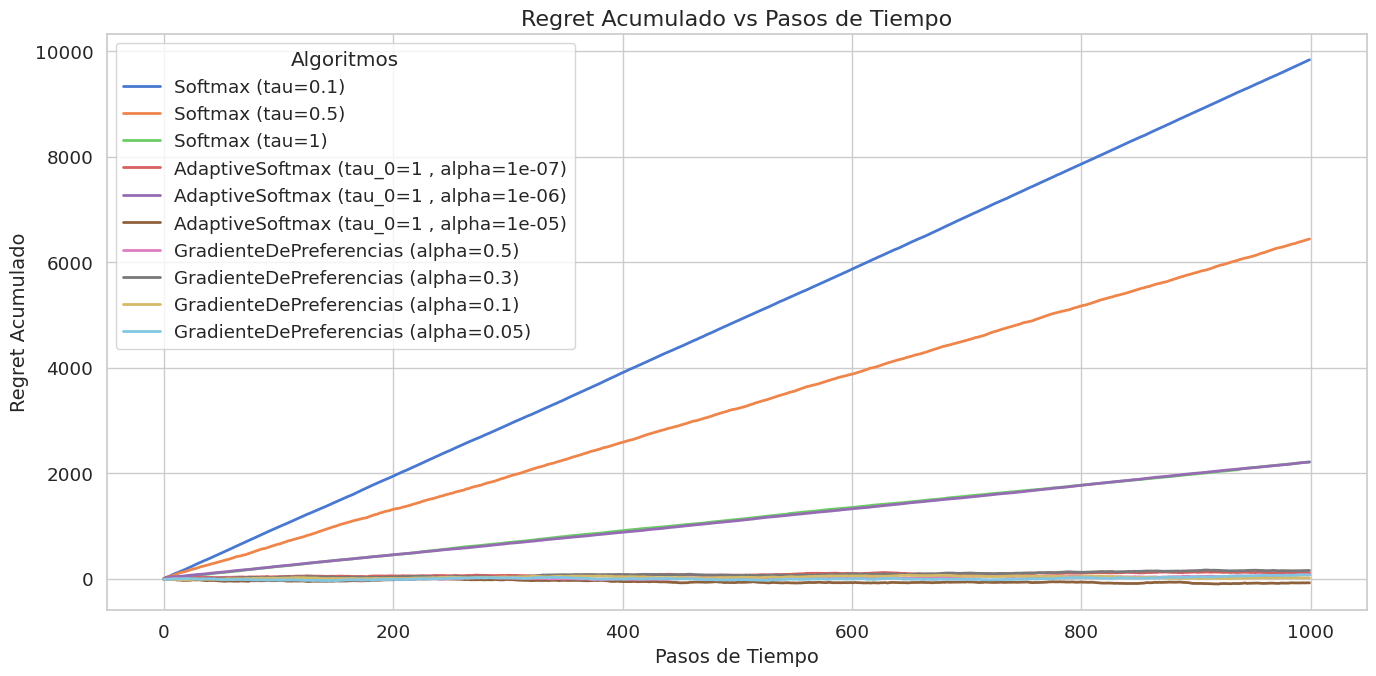

In [ ]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms)

Sorprendentemente, todos los algoritmos de gradiente de preferencias albergan un regret acumulado cercano al 0%, incluso los que nunca seleccionaban el brazo óptimo. También se acercan mucho a 0 en regret algunos algoritmos de Adaptive Softmax. Los siguientes ocn mejor rendimiento (aunque de lejos) son Softmax($\tau = 1$) y AdaptiveSoftmax().

## **[3] - Conclusiones de este estudio**

Como conclusión podemos determinar que los algoritmos de gradiente de preferencias son muy robustos respecto a los cambios en la distribución de los brazos del bandido, y que por lo general, los métodos softmax no consiguen un gran rendimiento en este problema, con cualesquiera dsitribuciones que asignemos a los brazos del bandido. Solo consiguen un resultado competente cuando la distribución es Binomial, y medianamente aceptable cuando es Bernoulli. Los métodos de gradiente de preferencias dan resultados excelentes para este problema. Esto pone en evidencia la robustez de los algoritmos *Softmax*, cosa que validaremos de nuevo al compararlos con los $\varepsilon$-greedy.